# Concatenaciones de ramas de Redes Neuronales Híbridas

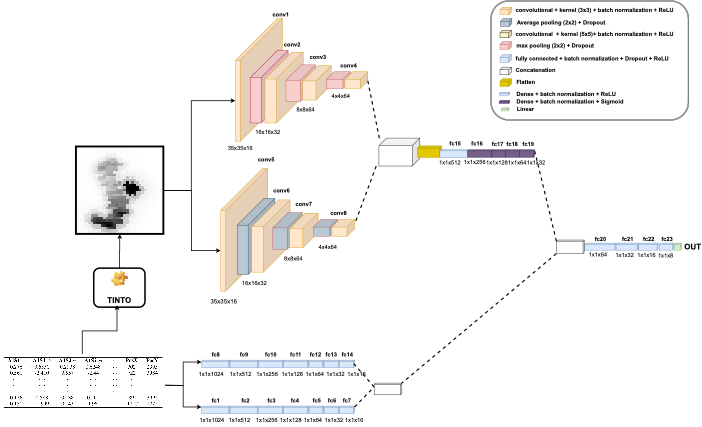

## Imports

In [1]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
#import cv2
import gc
import matplotlib.pyplot as plt
#import openslide
#from openslide.deepzoom import DeepZoomGenerator
import tifffile as tifi
import sklearn
import tensorflow as tf
import seaborn as sns
from PIL import Image


from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score,mean_absolute_percentage_error

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Softmax, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adamax
from tensorflow.keras import layers, models, Model
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.layers import Add, Multiply, Input, Activation,MaxPooling2D, concatenate, AveragePooling2D, Concatenate
from keras.utils import plot_model
#from imblearn.over_sampling import RandomOverSampler

#Models of TINTOlib
from TINTOlib.barGraph import BarGraph
from TINTOlib.combination import Combination
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.supertml import SuperTML
from TINTOlib.tinto import TINTO
from TINTOlib.featureWrap import FeatureWrap
from TINTOlib.bie import BIE

# SET RANDOM SEED FOR REPRODUCIBILITY
SEED = 64
#torch.manual_seed(SEED)
#torch.cuda.manual_seed(SEED)
#torch.cuda.manual_seed_all(SEED)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-04-08 15:24:56.717893: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 15:24:56.728623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744118696.741210   22776 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744118696.745258   22776 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744118696.755498   22776 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

##Read the dataset

In this part, we proceed to read the dataset.

In [3]:
dataset_name = 'boston'

#Read CSV
df = pd.read_csv(f"../resources/Datasets/{dataset_name}.csv")
df.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


In [4]:
df.shape

(506, 14)

To determine the appropriate size for a square image that contains all the feature pixels, you need to calculate the square root of the total number of features. The resulting value can be used for the methods that requires inserting the image size.

In [5]:
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

4


### Create images with TINTOlib

We prepare the declaration of the classes with the TINTOlib method we want to transform. Note that TINTOlib has several methods and we will have to choose one of them since each method generates different images.

In addition, we establish the paths where the dataset is located and also the folder where the images will be created.

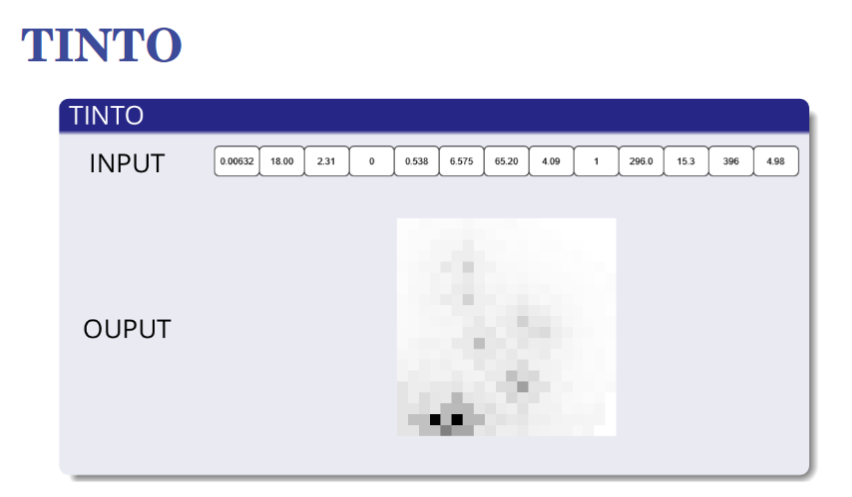

In [6]:
#Select the model and the parameters
#problem_type = "supervised"
problem_type = "regression"

# Transformation methods
image_model = TINTO(problem=problem_type, blur=True, option='maximum', pixels=20, random_seed=SEED)
name = f"TINTO_blur_maximum"


#Define the dataset path and the folder where the images will be saved
results_folder = f"Results/{dataset_name}_{name}"
images_folder = f"Synthetic_images/images_{dataset_name}_{name}"

## Generate images

In this section, we generate images from the dataset using three key functions of the image generation model:

- fit: Trains the image generation model without generating images. This function is used exclusively for training purposes.
- fit_transform: Trains the image generation model and simultaneously generates images for the dataset. This function is applied to the training dataset, where the model is both trained and used to create images.
- transform: Generates images using the pre-trained model. After training on the training dataset, this function is used to generate images for unseen data, such as validation and test datasets.

Each row in the dataset is transformed into a unique image, ensuring that the number of generated images matches the number of rows in the dataset. The resulting datasets include paths to these images, which are then combined with the original data for further processing.

Split the data into training, validation, and test sets:

In [7]:
import cv2
from sklearn.preprocessing import MinMaxScaler

X_train, X_val = train_test_split(df, test_size=0.20, random_state=SEED)
X_val, X_test = train_test_split(X_val, test_size=0.50, random_state=SEED)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

Define a function to streamline the repetitive process of generating images, updating paths, and combining datasets:

In [8]:
def process_dataset(X, folder_name, generate_function, problem_type):
    """
    Handles dataset processing, including image generation, path updates, 
    and combining the dataset with image paths.

    Parameters:
    ----------
    X : DataFrame
        The dataset to process (training, validation, or test).
    
    folder_name : str
        The name of the folder where generated images will be stored 
        (e.g., 'train', 'val', 'test').
    
    generate_function : function
        The function used for training and generating images. It can be one of the following:
        - `fit`: Trains the model without generating images.
        - `fit_transform`: Trains the model and generates images for the dataset (used for training).
        - `transform`: Uses the pre-trained model to generate images for validation and testing.
    
    problem_type : str
        The type of problem being addressed (e.g., regression, supervised).
        This is used to locate the corresponding `.csv` file containing image paths.

    Returns:
    --------
    X_processed : DataFrame
        The dataset with updated image paths and raw tabular data, ready for further processing.
    
    y_processed : Series
        The labels corresponding to the dataset (target values).
    """
    # Generate the images if the folder does not exist
    folder_path = f"{images_folder}/{folder_name}"
    if not os.path.exists(folder_path):
        generate_function(X, folder_path)
    else:
        print(f"The images for {folder_name} are already generated")

    # Load image paths
    img_paths = os.path.join(folder_path, f"{problem_type}.csv")
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = folder_path + "/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X], axis=1)

    # Split data and labels
    X_processed = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_processed = combined_dataset["values"]

    return X_processed, y_processed


In [9]:
### X_train
X_train, y_train = process_dataset(X_train, "train", image_model.fit_transform, problem_type)

In [10]:
### X_val
X_val, y_val = process_dataset(X_val, "val", image_model.transform, problem_type)

In [11]:
### X_test
X_test, y_test = process_dataset(X_test, "test", image_model.transform, problem_type)

## Pre-modelling phase

### Data curation

Note that each method generates images of **different pixel size**. For example:
- `TINTO` method has a parameter that you can specify the size in pixels which by default is 20.
- Other parameters such as `Combined` generates the size automatically and you must obtain them from the _shape_ of the images.

In [12]:
#TIDY DATA SPLITTED
X_train_num = X_train.drop("images",axis=1)
X_val_num = X_val.drop("images",axis=1)
X_test_num = X_test.drop("images",axis=1)

#IMAGES
# For 3 channels (RGB)
X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

# For 1 channels (GRAY SCALE)
"""X_train_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_test["images"]])"""

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale numerical data
X_train_num = scaler.fit_transform(X_train_num)
X_val_num = scaler.transform(X_val_num)
X_test_num = scaler.transform(X_test_num)

attributes = X_train_num.shape[1]
height, width, channels = X_train_img[0].shape

imgs_shape = (height, width, channels)

print("Images shape: ",imgs_shape)
print("Attributres: ",attributes)
pixel=X_train_img[0].shape[0]
print("Image size (pixels):", pixel)

Images shape:  (20, 20, 3)
Attributres:  13
Image size (pixels): 20


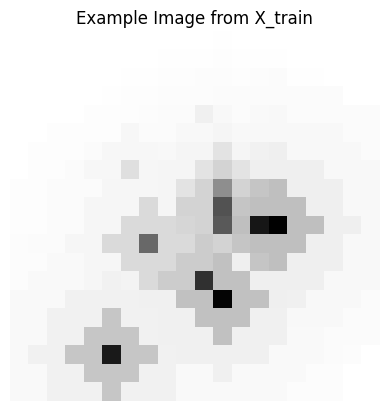

In [13]:
# Plot an example image (e.g., the first image in the array)
example_image = X_train_img[0]

# Convert the image from BGR (OpenCV default) to RGB for correct color display
example_image_rgb = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(example_image_rgb)
plt.title("Example Image from X_train")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()

In [14]:
X_train_img = X_train_img/255
X_val_img = X_val_img/255
X_test_img = X_test_img/255

## Modeling hybrid network

Now we can start the CNN+MLP training. Before that we prepare the algorithm for reading data.

### FFNN for tabular data

This is an example of a simple and more complex FFNN for tabular data. Note that we are not looking for the optimization of the CNN+MLP but to show an example of TINTOlib execution.

In [15]:
dropout = 0.1

In [16]:
# Single branch FFNN
ff_inputs = Input(shape = (attributes,))

mlp_1 = Dense(64, activation='relu')(ff_inputs)
mlp_1 = Dense(32, activation='relu')(mlp_1)
mlp_1 = Dense(16, activation='relu')(mlp_1)
ff_model = Model(inputs = ff_inputs, outputs = mlp_1)

I0000 00:00:1744118993.860065   22776 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 966 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


### CNN for TINTOlib images

This is an example of a simple and more complex CNN for TINTOlib images. Note that we are not looking for the optimization of the CNN+MLP but to show an example of TINTOlib execution.

In [17]:
dropout = 0.1

In [18]:
# Single branch CNN
#Input
input_shape = Input(shape=imgs_shape)

# CNN branch 1
tower_1 = Conv2D(16, (3,3), activation='relu',padding="same")(input_shape)
tower_1 = Activation('relu')(tower_1)
tower_1 = MaxPooling2D(2,2)(tower_1)

tower_1 = Conv2D(32, (3,3), activation='relu',padding="same")(tower_1)
tower_1 = Activation('relu')(tower_1)

tower_1 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1)
tower_1 = Activation('relu')(tower_1)

#Flatten
merged = Flatten()(tower_1)

#Dense layers
out = Dense(128, activation='relu')(merged)
out = Dense(48, activation='relu')(out)
#out = Dense(32, activation='relu')(out)

cnn_model = Model(input_shape, out)

### Concatenate branches

Finally, we need to fuse the CNN and MLP branches. In this case, we use a direct concatenation of the output from the CNN branch with the output from the MLP branch, feeding them into a final fully connected neural network (FFNN) that will produce the predictions.

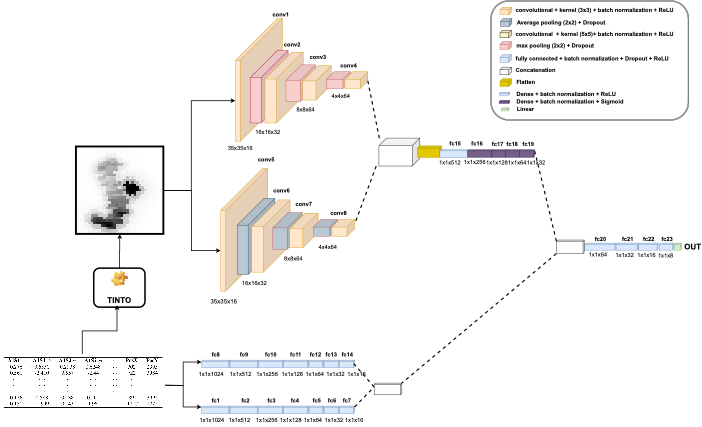


### Direct Concatenation


In [19]:
combinedInput = concatenate([ff_model.output, cnn_model.output])
x = Dense(48, activation="relu")(combinedInput)
x = Dense(24, activation="relu")(x)
x = Dense(1, activation="linear")(x)
model = Model(inputs=[ff_model.input, cnn_model.input], outputs=x)


### Concatenation with Attention


In [20]:
# Concatenate the outputs of the two branches (MLP and CNN)

concat_features = Concatenate(axis=1)([ff_model.output, cnn_model.output])

# Compute attention weights using a dense layer
# The output of this layer will match the total number of concatenated features
attention_weights = Dense(concat_features.shape[1], activation='softmax')(concat_features)

# Apply attention weights to the concatenated branch features
# Multiplying the features by attention weights focuses on the most important ones
weighted_features = Multiply()([concat_features, attention_weights])

# Additional dense layers after attention-based fusion
x = Dense(48, activation="relu")(weighted_features)
x = Dense(24, activation="relu")(x)
x = Dense(1, activation="linear")(x)
model = Model(inputs=[ff_model.input, cnn_model.input], outputs=x)

### Attention Fusion


In [44]:
# Concatenate the outputs of the two branches (MLP and CNN)
concat_features = Concatenate(axis=1)([ff_model.output, cnn_model.output])

# Attention-based fusion
attention_weights = Dense(2, activation='softmax')(concat_features)
attention_output = Add()([Multiply()([attention_weights[:, 0:1], ff_model.output]),
                          Multiply()([attention_weights[:, 1:2], cnn_model.output])])

# Additional dense layers after attention-based fusion
x = Dense(48, activation="relu")(attention_output)
x = Dense(24, activation="relu")(x)
x = Dense(1, activation="linear")(x)
model = Model(inputs=[ff_model.input, cnn_model.input], outputs=x)


### Transformer-Encoder Fusion


In [21]:
from keras.layers import MultiHeadAttention, LayerNormalization, Lambda

# Concatenar las salidas de ambas ramas para formar la entrada del Transformer
transformer_input = Concatenate(axis=1)([ff_model.output, cnn_model.output])

# Añadir una dimensión para que MultiHeadAttention lo trate como una secuencia
transformer_input = Lambda(lambda x: tf.expand_dims(x, axis=1))(transformer_input)

# Bloque Transformer: Multi-Head Attention
attention_output = MultiHeadAttention(num_heads=6, key_dim=64)(transformer_input, transformer_input)

# Residual Connection + Layer Normalization
attention_output = Add()([transformer_input, attention_output])
attention_output = LayerNormalization()(attention_output)

# Feed-Forward dentro del bloque Transformer
transformer_ff = Dense(256, activation="relu")(attention_output)
transformer_ff = Dropout(dropout)(transformer_ff)
transformer_ff = Dense(128, activation="relu")(transformer_ff)
transformer_ff = Dropout(dropout)(transformer_ff)
transformer_ff = Dense(64, activation="relu")(transformer_ff)

# Residual Connection + Layer Normalization
transformer_output = Add()([attention_output, transformer_ff])
transformer_output = LayerNormalization()(transformer_output)

# Aplanar la salida del Transformer
flattened_output = Flatten()(transformer_output)

# Capas finales después de la fusión
x = Dense(64, activation="relu")(flattened_output)
x = Dense(32, activation="relu")(x)
x = Dense(16, activation="relu")(x)
x = Dense(8, activation="relu")(x)
x = Dense(1, activation="linear")(x)

# Modelo final
model = Model(inputs=[ff_model.input, cnn_model.input], outputs=x)


## Metrics

Define metrics and some hyperparameters

In [22]:
import tensorflow.keras.backend as K

def r_square(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2

METRICS = [
    tf.keras.metrics.MeanSquaredError(name = 'mse'),
    tf.keras.metrics.MeanAbsoluteError(name = 'mae'),
    tf.keras.metrics.RootMeanSquaredError(name = 'rmse'),
    r_square,
]

Print the hybrid model

In [23]:
os.makedirs(results_folder, exist_ok=True)

# Redirect the summary output to the specified file
with open(results_folder+"/model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Disable automatic matplotlib display
plt.ioff()
# Save the model plot
plot_model(model, to_file=results_folder+'model_plot.png', show_shapes=True, expand_nested=True)
# Re-enable automatic matplotlib display (optional)
plt.ion()

## Compile and fit


In [24]:
opt = Adam()

In [25]:
model.compile(
    loss="mse",
    optimizer=opt,
    metrics = METRICS
)

In [26]:
# Configure EarlyStopping for binary classification
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation accuracy
    min_delta=0.001,         # Minimum change in the monitored quantity to qualify as an improvement
    patience=10,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # Log when training stops
    mode='min',              # Maximize the accuracy; min the loss
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [27]:
model_history=model.fit(
    x=[X_train_num, X_train_img], y=y_train,
    validation_data=([X_val_num, X_val_img], y_val),
    epochs=50,
    batch_size=16,
    callbacks = [early_stopper]
)

Epoch 1/50


I0000 00:00:1744119230.690603   23746 service.cc:152] XLA service 0x7f8a98002f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744119230.690630   23746 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-04-08 15:33:50.757515: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744119231.340825   23746 cuda_dnn.cc:529] Loaded cuDNN version 90800


15/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 448.8250 - mae: 19.0301 - mse: 448.8250 - r_square: -6.1686 - rmse: 21.0295 

I0000 00:00:1744119235.328090   23746 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 456ms/step - loss: 396.1369 - mae: 17.5906 - mse: 396.1369 - r_square: -5.5728 - rmse: 19.7588 - val_loss: 87.8839 - val_mae: 7.2450 - val_mse: 87.8839 - val_r_square: -1.6919 - val_rmse: 9.3746
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 91.4777 - mae: 6.7339 - mse: 91.4777 - r_square: -0.2407 - rmse: 9.4576 - val_loss: 62.3138 - val_mae: 5.8685 - val_mse: 62.3138 - val_r_square: -0.2630 - val_rmse: 7.8939
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 65.9542 - mae: 5.8310 - mse: 65.9542 - r_square: 0.0599 - rmse: 8.0792 - val_loss: 48.7679 - val_mae: 5.8190 - val_mse: 48.7679 - val_r_square: -2.2210 - val_rmse: 6.9834
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 44.3781 - mae: 4.9521 - mse: 44.3781 - r_square: 0.3324 - rmse: 6.6391 - val_loss: 34.4198 - val_mae: 4.6144 - val_mse: 34.4198 - val_r_square: -0.8985 - val_rmse: 5.8668
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29.4659 - mae: 3.8628 - mse:

In [28]:
print(model_history.history.keys())

dict_keys(['loss', 'mae', 'mse', 'r_square', 'rmse', 'val_loss', 'val_mae', 'val_mse', 'val_r_square', 'val_rmse'])


## Results

Finally, we can evaluate our hybrid model with the images created by TINTOlib in any of the ways represented below.

### Train/Validation representation

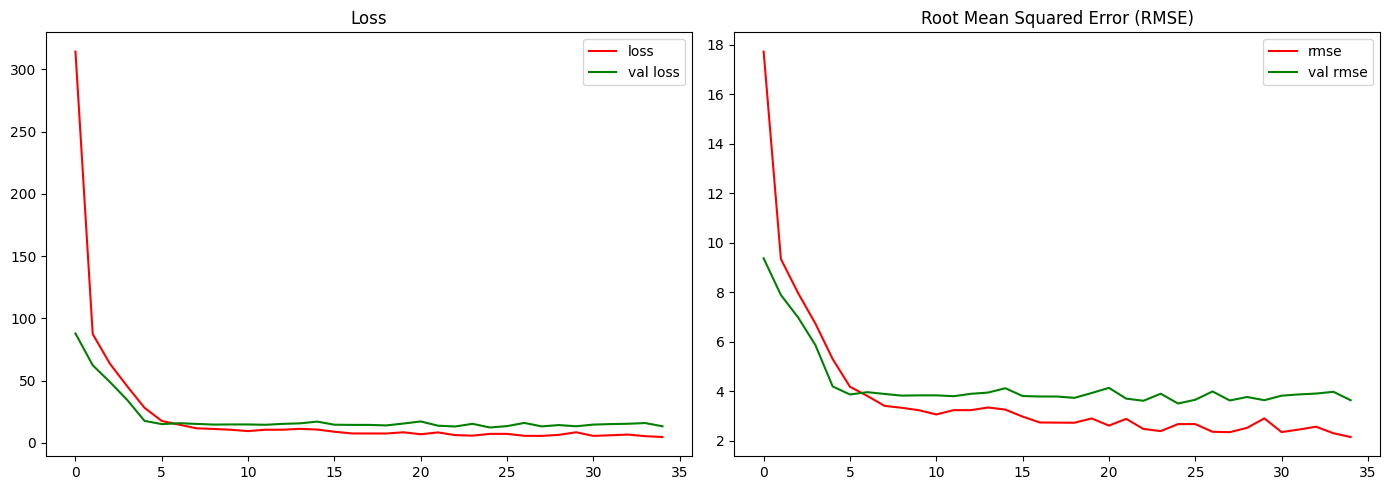

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Subplot 1: Loss
axes[0].plot(model_history.history['loss'], color='red', label='loss')
axes[0].plot(model_history.history['val_loss'], color='green', label='val loss')
axes[0].set_title('Loss')
axes[0].legend(loc='upper right')

# Subplot 2: RMSE
axes[1].plot(model_history.history['rmse'], color='red', label='rmse')
axes[1].plot(model_history.history['val_rmse'], color='green', label='val rmse')
axes[1].set_title('Root Mean Squared Error (RMSE)')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

### Validation/Test evaluation

In [30]:
score_test= model.evaluate([X_val_num, X_val_img], y_val)

2025-04-08 15:35:13.902442: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 4 bytes spill stores, 4 bytes spill loads

2025-04-08 15:35:14.117205: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 12 bytes spill stores, 12 bytes spill loads



1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - loss: 13.5261 - mae: 2.6567 - mse: 13.5261 - r_square: 0.8260 - rmse: 3.6778

2025-04-08 15:35:16.299061: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 4 bytes spill stores, 4 bytes spill loads

2025-04-08 15:35:16.307683: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_161', 12 bytes spill stores, 12 bytes spill loads

2025-04-08 15:35:16.609976: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 12 bytes spill stores, 12 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 12.7120 - mae: 2.5621 - mse: 12.7120 - r_square: 0.7749 - rmse: 3.5645


In [31]:
prediction = model.predict([X_test_num,X_test_img])

test_mape = mean_absolute_percentage_error(y_test, prediction)
test_mae = mean_absolute_error(y_test, prediction)
test_mse = mean_squared_error(y_test, prediction)
test_rmse = root_mean_squared_error(y_test, prediction)
test_r2 = r2_score(y_test, prediction)

# Print the evaluation metrics
print("Mean Absolute Percentage Error:", test_mape)
print("Mean Absolute Error:", test_mae)
print("Mean Squared Error:", test_mse)
print("Root Mean Squared Error:", test_rmse)
print("R2 Score:", test_r2)

# Define the metrics and their values
metrics = {
    "Mean Absolute Percentage Error": test_mape,
    "Mean Absolute Error": test_mae,
    "Mean Squared Error": test_mse,
    "Root Mean Squared Error": test_rmse,
    "R2 Score": test_r2,
}

# Save the metrics to a text file
with open(f"{results_folder}/metrics.txt", "w") as file:
    for metric, value in metrics.items():
        file.write(f"{metric}: {value}\n")

print(f"Metrics saved to {results_folder}/metrics.txt")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
Mean Absolute Percentage Error: 0.10928040037227328
Mean Absolute Error: 2.322377530266257
Mean Squared Error: 11.300512954069161
Root Mean Squared Error: 3.3616235592447232
R2 Score: 0.8935543609483385
Metrics saved to Results/boston_TINTO_blur_maximum/metrics.txt


In [32]:
train_mse = model_history.history["mse"][-1]
train_r2 = model_history.history["r_square"][-1]

val_mse = model_history.history["val_mse"][-1]
val_r2 = model_history.history["val_r_square"][-1]

print("Train Mean Squared Error:", train_mse)
print("Train R2 Score:", train_r2)

print("Val Mean Squared Error:", val_mse)
print("Val R2 Score:", val_r2)

Train Mean Squared Error: 4.640835762023926
Train R2 Score: 0.9169738292694092
Val Mean Squared Error: 13.253958702087402
Val R2 Score: 0.7182533144950867


<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>